# Sentiment Analysis Library Comparison

The objective is to compare three available Python libraries for performing [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). The comparison will be done on both performance of the algorithm in successfully detecting the **sentiment** as well as computation.

The libraries to be examined are:
* [TextBlob](https://textblob.readthedocs.io/en/dev/)
* [Polyglot](https://polyglot.readthedocs.io/en/latest/index.html)
* [Google NL](https://cloud.google.com/natural-language/)

In order to compare the accuracy of the three different libraries, a tagged dataset is required. For the purposes of this test the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) was chosen, compiled by Andrew Mass for Stanford. The data is split into two top level groups. One used for training a model, named train and another used for testing it, named, test. Within each one are the two classes, positive and negative, again split into two directories. For the purposes of this test we will be using only the training data which contains 25000 entries. This tets data, though, will be limited to 6000 movie review, simply for time economy.


## Configuration

In order to load the data, use the libraries and compare the results the followign Python libraries are needed.
* pandas
* sklearn
* numpy
* textblob
* polyglot
* google-cloud-language

These packages can all be installed by executing the following command.

```console
pip install --upgrade google-cloud-language textblob polyglot \
    pandas sklearn numpy
```

For **Polyglot** specifically, you should also install the corresponding language corpus. In our case this is English.
```console
polyglot download sentiment2.en
```

The **Google Natural Language** library requires a connection to the Google API. In order to do so you must create a credentials json file and supply it. You can find instructions on how to do this [here](https://cloud.google.com/natural-language/docs/quickstart-client-libraries).


In [1]:
%load_ext memory_profiler

In [2]:
import os
import glob
import pandas as pd
import numpy as np

## Loading the training data

We must now load the training data that will used to test the libraries.

In [3]:
data_file_directory = 'Large Movie Review Dataset/train'

Determine the number of rows to use.

In [4]:
number_of_files = 100
#number_of_files = len(os.listdir(positives)) + len(os.listdir(negatives))

A [Numpy Structure array](https://docs.scipy.org/doc/numpy/user/basics.rec.html?#module-numpy.doc.structured_arrays) is defined along with all the relevant field that will used futher on. The ground truth, extracted from the training data files and the results from each of the libraries.

The array is initialized and populated with `0`s in every field.

In [5]:
data = np.zeros(number_of_files, dtype=
                {
                    'names':(
                        'movie_id', 
                        'movie_rating', 
                        'review', 
                        'truth', 
                        'textblob',
                        'textblob_class',
                        'polyglot', 
                        'polyglot_class',
                        'google', 
                        'google_class'),
                    'formats':(
                        'i2', 
                        'i1', 
                        'U15000', 
                        'U8', 
                        'f8',
                        'U8',
                        'f8',
                        'U8',
                        'f8', 
                        'U8'),
                }
               )

Initialize the arrays that will later populate the Numpy array.

In [6]:
ids = []
ratings = []
reviews = []
true_values = []

The `get_data_from_files` method is defined to avoid double work. Since the two classes are divided into two separate directories and the values differ we call the methods twice, once for each class. The only input required is the string declaring whether the `positive` labels will be collected or the `negative`.

In [7]:
def get_data_from_files(category):
    if category is 'positives':
        subdir_name = os.path.join(data_file_directory, 'pos')
        truth = 'positive'
    elif category is 'negatives':
        subdir_name = os.path.join(data_file_directory, 'neg')
        truth = 'negative'
    print("Retrieving " + category + "...")

    for filename in glob.glob(os.path.join(subdir_name, '*.txt')):
        movie_id, movie_rating = os.path.splitext(os.path.basename(filename))[0].split('_')
        ids.append(movie_id)
        ratings.append(movie_rating)
        review_text = ''.join(x for x in open(filename, 'r').read() if x.isprintable())
        reviews.append(review_text)
        true_values.append(truth)

Retrieve all training data for the "positives"

In [8]:
get_data_from_files('positives')
print('Retrieved {} records'.format(len(ids)))

Retrieving positives...
Retrieved 12500 records


Retrieve all the training data for the "negatives"

In [9]:
get_data_from_files('negatives')
print('Retrieved {} records'.format(len(ids)))

Retrieving negatives...
Retrieved 25000 records


Now, the retrieved data will be passed to the `data` numpy array which was declared earlier.

The reason for spliting the arrays and storing the first and second half separately is because if we choose to use a subset of the retrieved labels we want it to be balanced. Since the data is stroed in sequence with the first half belonging to one label and the second the other this is a safe approach. If we were to retrieve the first `x` number of elements they would either be exclusively from one class or heavily biased toward it.

In [10]:
data['movie_id'] = ids[:int(number_of_files/2)] + ids[-int(number_of_files/2):]
data['movie_rating'] = ratings[:int(number_of_files/2)] + ratings[-int(number_of_files/2):]
data['review'] = reviews[:int(number_of_files/2)] + reviews[-int(number_of_files/2):]
data['truth'] = true_values[:int(number_of_files/2)] + true_values[-int(number_of_files/2):]
print("Total Population: {}\nPositive Population: {}\nNegative Population: {}".format(
    len(data), 
    len(data[data['truth'] == 'positive']), 
    len(data[data['truth'] == 'negative']))
     )

Total Population: 6000
Positive Population: 3000
Negative Population: 3000


___
# Collecting the test data

We are now ready to start collecting the data from the libraries. We will send each movie review from our test data to each library for parsing and collected the results for further analysis.

## Textblob

First import the textblob module.

In [11]:
from textblob import TextBlob

A method is defined that will actually use `TextBlob`. This will let us get performance metrics as well.

In [12]:
def use_textblob():
    with np.nditer(data, op_flags=['readwrite']) as movie:
        for field in movie:
            blob = TextBlob(str(field['review']))
            field['textblob'] = blob.sentiment.polarity

The method is now executed and at the same time collect runtime and memory usage for performance comparison later on.

In [13]:
%%timeit -r 1 -n 1 -o
%memit -r 1 use_textblob()

peak memory: 605.05 MiB, increment: 63.11 MiB
29.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 29.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [14]:
textblob_runtime = _

In [15]:
print("Best TextBlob execution time was {}s".format(textblob_runtime.best))

Best TextBlob execution time was 29.763123613010976s


## Polyglot

We start by importing the module.

In [16]:
from polyglot.text import Text

Again, a method is defined to retrieve the sentiment using `Polyglot` this time.

In [17]:
def use_polyglot():
    with np.nditer(data, op_flags=['readwrite']) as movie:
        for field in movie:
            text = Text(str(field['review']))
            field['polyglot'] = text.polarity

The method is executed and performance metrics collected.

In [18]:
%%timeit -r 1 -n 1 -o
%memit -r 1 use_polyglot()

peak memory: 1086.57 MiB, increment: 507.96 MiB
34.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 34.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [19]:
polyglot_runtime = _

In [20]:
print("Best Polyglot execution time was {}s".format(polyglot_runtime.best))

Best Polyglot execution time was 34.8659720680007s


## Google

As before, we begin by including the library. In the case of Google's API we need to include more than one items.

In [21]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

Once more, a method is defined to use the library.

In [22]:
def use_google():
    client = language.LanguageServiceClient.from_service_account_json('credentials.json')
    with np.nditer(data, op_flags=['readwrite']) as movie:
        for field in movie:
            document = types.Document(content=str(field['review']), type=enums.Document.Type.PLAIN_TEXT)
            sentiment = client.analyze_sentiment(document=document).document_sentiment
            field['google'] = sentiment.score

The method is executed the the performance statistics collected.

In [23]:
%%timeit -r 1 -n 1 -o
%memit -r 1 use_google()

peak memory: 618.47 MiB, increment: 5.19 MiB
53min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 53min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [24]:
google_runtime = _

In [25]:
print("Best Google NL execution time was {}s".format(google_runtime.best))

Best Google NL execution time was 3233.6972786269907s


Since all the libraries used return results in the `[-1, 1]` range and we only know an absolute `-1` or `1` from the ground truth it would be helpful to convert the data to a pseudo binary class.
Therefore any value above `0` will be convert to `positive`, anything below `0` to `negative` and anything equal `0` to `neutral`.

In [26]:
classify = lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
vfunc = np.vectorize(classify)
data['textblob_class'] = vfunc(data['textblob'])
data['polyglot_class'] = vfunc(data['polyglot'])
data['google_class'] = vfunc(data['google'])

In [2]:
data[:2]

NameError: name 'data' is not defined

# Performance
It is a good time now to compare runtime between the three libraries.

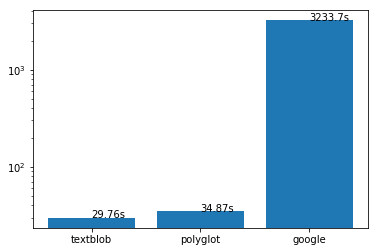

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
time_values = (np.mean(textblob_runtime.all_runs), np.mean(polyglot_runtime.all_runs),np.mean(google_runtime.all_runs))
lib_names = ('textblob', 'polyglot', 'google')
plt.bar(lib_names, time_values, log=True)
for a,b in zip(lib_names, time_values):
    plt.text(a,b,str(round(b,2))+"s")
plt.show()

Notice that the above chart is a logarithmic bar chart. The time required by the google API is two orders of magnitude greater that that of the other two.

If performance related to time is a significant factor for a proposed application then **Polyglot** and **TextBlob** are better contenders. On the other hand since all of the computation node is offloaded to Google's servers when one uses its API, there is no performance impact. Compation wise, **Google** is the most economic, thought it does require more memory.

# Storing the data
The last step is to store the data for further processing.

In [ ]:
pdata = pd.DataFrame(data)
pdata.to_pickle('complete_data')